# infos

In [49]:
# Modèle basé sur les 10 espèces représentées


# Vérifier que les chemins soient correct avant toutes opérations
chemin_images = '../../images/'
chemin_csv = '../data/top10.csv'

# Définition du DataFrame echantillon (utile pour tests modèles car entrainements très rapides)
pourcentage_echantillon = 0.1 # Si 0.1 : 10% du contenu

# Dimensions des images
img_dim = (224,224)
img_shape = (224,224,3)

##### A faire sur le notebook :

- S'assurer que la data augmentation lisse le nb d'images par classe (modifier dans les fonctions) <-- Fait  mais à controler
- Dans évaluation du modèle, compléter la dernière cellule (affichage images avec classe réelle et classe prédite)
- Configurer Tensorboard (ajouter des fonctionnalités)

# Google Colab

Si le notebook tourne sur colab, charger les fichiers images (format zip) et dezipper en suivant les cellules qui suivent :

In [ ]:
# Importer les images en format .zip
from google.colab import files
files.upload()

In [ ]:
# Dezipper le fichier
fichier_source = 
dossier_sortie = 
!unzip fichier_source -d dossier_sortie

# Librairies à charger

In [91]:
# Librairies utilisées par les fonctions
import pandas as pd
import os
from tensorflow.keras.applications.efficientnet import preprocess_input


# Librairies utilisées pour les callbacks
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from timeit import default_timer as timer
from tensorflow.keras.callbacks import TerminateOnNaN


# Librairies utilisées pour créer les pipelines et le modèle
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models


# Librairies utilisées pour la création des jeux d'entrainement, de test et de validation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter


# Librairies utilisées pour l'évaluation du modèle une fois entrainé
import matplotlib.pyplot as plt
%matplotlib inline
import random

# Fonctions

In [51]:
def import_df(chemin_images, chemin_csv, pourcentage_echantillon):
    '''Importe le fichier csv et construit 2 df :
        - Le DF basé sur le CSV original
        - Un DF echantillon comportant 10% de données aléatoires du DF original

        '''
    
    
    # import du df
    df = pd.read_csv(chemin_csv, low_memory=False)
    df['image_url'] = df['image_url'].str.replace('.../images/', chemin_images)
    print(f"Nombre d'images chargées pour df: {df.shape[0]}")
    print(f"Nb especes dans df: {df['label'].nunique()}")


    # Contruction de l'echantillon
    L = len(df)
    L_ech = int(pourcentage_echantillon * L)
    df_ech = df.sample(n=L_ech, random_state=10)
    df_ech.reset_index(inplace=True, drop=True)
    print(f"Nombre d'images chargées pour df_ech: {df_ech.shape[0]}")
    print(f"Nb especes dans df_ech: {df_ech['label'].nunique()}")




    return df, df_ech

In [52]:
def augment_img(image_path, label):

    '''Modifie les images aléatoirement dans le dataset qui sera soumis au modèle, oversample les classes sous représentées.
       image_path : chemin des images (variable définie en début de notebook),
       label : Variable contenant les classes,
       oversample_cls : Liste de classes à oversampler (Defini lors de l'import des données)
       '''

    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, img_dim)         # Rappel : img_dim est définie en début de Notebook
    img = preprocess_input(img)

    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = (img - tf.math.reduce_min(img)) / (tf.math.reduce_max(img) - tf.math.reduce_min(img))


    return img, label

In [53]:
def create_tf_dataset(image_path, labels, batch_size, oversample_cls = None):
    '''
    Créé un dataset Tensorflow selon les paramètres précisés. La fonction oversample les classes sous représentées
    image_path : chemin relatif de la variable contenant les images
    labels : variable contenant les labels
    batch_size : taille des batchs
    iversample_cls : Liste contenant les classes à oversampler. Si non précisé, l'oversample sera ignoré
    '''

    image_path = image_path.tolist()  # Convertir les chemins d'images en liste
    labels = labels.tolist()          # Convertir les labels en liste


 # Oversample des classes
    if oversample_cls:
    # Compter le nombre d'exemples par classe
        class_counts = Counter(labels)

    # Calculer le nombre d'exemples à ajouter pour chaque classe à oversampler
        max_count = max(class_counts.values())
        facteurs_oversample = {cls: max_count / count for cls, count in class_counts.items() if cls in oversample_cls}

    # Répéter les exemples des classes à oversampler pour atteindre le nombre maximum
        oversampled_image_paths = []
        oversampled_labels = []
        for img_path, label in zip(image_path, labels):
            facteurs_oversample = facteurs_oversample.get(label, 1.0)
            nb_copies = int(facteurs_oversample)
            for _ in range(nb_copies):
                oversampled_image_paths.append(img_path)
                oversampled_labels.append(label)

        image_path = oversampled_image_paths
        labels = oversampled_labels



    # Construction du Dataset    
    dataset = tf.data.Dataset.from_tensor_slices((image_path, labels))
    dataset = dataset.map(augment_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(image_path))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

In [54]:
def controle_presence_fichiers(df, chemin_images):

    ''' Controle que les fichiers images soient bien présents sur le disque.'''

    image_directory = chemin_images
    missing_files = []

# Parcourir chaque ligne du DataFrame
    for index, row in df.iterrows():
        image_path = os.path.join(image_directory, row['image_lien'])
    
        if not os.path.exists(image_path):
            missing_files.append(image_path)

    # Afficher les fichiers non trouvés
    if missing_files:
        print("\nFichiers non trouvés :")
        for file_path in missing_files:
            print(file_path)
    else:
        print("\nTous les fichiers sont présents.")

# Callbacks

### Tensorboard

In [55]:
%load_ext tensorboard
log_dir = '../tensor_board_logs'
tensorboard = callbacks.TensorBoard(log_dir = log_dir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### EarlyStopping

In [56]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.05,
                               patience = 3,
                               verbose = 1,
                               mode = 'auto',
                               restore_best_weights = True)

### Reduce LearningRate

In [57]:
reduceLR = ReduceLROnPlateau(monitor = 'val_loss',
                             min_delta = 0.01,
                             patience = 3,
                             factor = 0.15, 
                             cooldown = 3,
                             verbose = 1)

### Checkpoint

In [58]:
checkpoint = ModelCheckpoint(filepath='../model/checkpoint_model', monitor='val_accuracy', save_best_only=True, verbose=1)

### Timer

In [79]:
class TimingCallback(Callback):
    def __init__(self):
        super().__init__()
        self.logs = []

    def on_epoch_begin(self, epoch, logs=None):
        self.starttime = timer()

    def on_epoch_end(self, epoch, logs=None):
        endtime = timer()
        elapsed_time = endtime - self.starttime
        self.logs.append(elapsed_time)
        print(f"Epoch {epoch + 1} took {elapsed_time:.2f} seconds")

time_callback = TimingCallback()

### Terminate on NaN

In [60]:
TON = TerminateOnNaN()

# Construction modèle

### Import du modèle pré-entrainé

In [61]:
# Import du modèle
# Le code qui suit est dépendant de la livrairie tensorflow_hub

# URL du modèle pré-entrainé
model_fit_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/classification/2'

# Chargement du modèle, freeze des couches du modèle
import_model = hub.KerasLayer(model_fit_url, trainable=False)

In [62]:
# Pré-contruction du modèle sans les couches denses du modèke pré-entrainé

input_layer = layers.Input(shape=img_shape) # La variable est définie en début de Notebook
x = import_model(input_layer)
pre_train_model = models.Model(inputs=input_layer, outputs=x)

### Couches denses et construction

In [63]:
# Créer le modèle CNN
model = models.Sequential()
model.add(pre_train_model)

# Couches entièrement connectées
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))  # 10 classes de sortie


### Compilation du modèle

In [65]:
# Compiler le modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [66]:
# Afficher un résumé du modèle
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 1000)              7200312   
                                                                 
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                64064     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 7266786 (27.72 MB)
Trainable params: 664

# Pipeline Dataset

### Import des DataFrames

In [67]:
# Rappel : Utiliser df_ech pour les tests (entrainement rapide du modèle mais accuracy faible)
df, df_ech = import_df(chemin_images, chemin_csv, pourcentage_echantillon)

Nombre d'images chargées pour df: 64372
Nb especes dans df: 10
Nombre d'images chargées pour df_ech: 6437
Nb especes dans df_ech: 10


C:\Users\guill\AppData\Local\Temp\ipykernel_15668\465607992.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df['image_url'] = df['image_url'].str.replace('.../images/', chemin_images)


In [68]:
# Préciser sur quelles données travailler (df_ech est un echantillo npermettant de réduire le temps d'entrainement pour effectuer des tests)
# Commenter/Decommenter la ligne souhaitée
donnees_training = df_ech
#donnees_training = df

In [69]:
# Représentation des classes
print('Facteurs d\'oversampling des classes : \n',
      'Agaricales : x1 \n',
      'Agaricus: x2.5 \n',
      'Amanita : x2 \n',
      'Cortinarius: x1.5 \n',
      'Entoloma : x2.5 \n',
      'Inocybe: x2 \n',
      'Mycena : x2 \n',
      'Popyporales: x1.8 \n',
      'Psathyrella : x2 \n',
      'Russula: x1.5 \n')

donnees_training.groupby('label').count()

Facteurs d'oversampling des classes : 
 Agaricales : x1 
 Agaricus: x2.5 
 Amanita : x2 
 Cortinarius: x1.5 
 Entoloma : x2.5 
 Inocybe: x2 
 Mycena : x2 
 Popyporales: x1.8 
 Psathyrella : x2 
 Russula: x1.5 



,image_lien,image_url
label,,
Agaricales,1173,1173
Agaricus,458,458
Amanita,524,524
Cortinarius,738,738
Entoloma,413,413
Inocybe,561,561
Mycena,519,519
Polyporales,677,677
Psathyrella,562,562


In [70]:
# Controle de la présence des fichiers images
controle_presence_fichiers(donnees_training, chemin_images)

# On supprime ensuite la colonne image_lien qui ne sert qu'à controler la présence des fichiers.
df.drop('image_lien', axis=1, inplace=True)
df_ech.drop('image_lien', axis=1, inplace=True)


Tous les fichiers sont présents.


In [71]:
# Définir les classes à oversampler :
oversample_cls = ['Agaricus', 'Amanita', 'Cortinarius', 'Entoloma', 'Inocybe', 'Mycena', 'Polyporales', 'Psathyrella', 'Russula']

### Construction des jeux de données (train, test et validation)

In [72]:
data = donnees_training.drop('label', axis=1)
target = donnees_training['label']

s = LabelEncoder()
target = s.fit_transform(target) # Encodage de la variable 'label'

# On construit le jeu d'entrainnement. X_temp et y_temps servent pour la construction des jeux de test et validation
X_train, X_temp, y_train, y_temp = train_test_split(data, target, test_size=0.25, random_state=10)

# On split les temp en 50% pour test, 50% pour validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

### Construction des dataset Tensorflow

In [73]:
batch_size = 64
# Les datasets sont créés à partir de la fonction create_tf_dataset définie dans la partie 'Fonctions'
ds_train= create_tf_dataset(X_train.image_url, y_train, batch_size, oversample_cls = oversample_cls)
ds_test = create_tf_dataset(X_test.image_url, y_test, batch_size)
ds_val = create_tf_dataset(X_val.image_url, y_val, batch_size, oversample_cls = oversample_cls)

# Entrainement du modèle

### Methode .fit

In [81]:
history = model.fit(ds_train,
                    validation_data = ds_val,
                    epochs=50,
                    callbacks = [tensorboard, early_stopping, reduceLR, checkpoint, time_callback, TON],
                    verbose=True)

Epoch 1/50


76/76 [==============================] - ETA: 0s - loss: 1.8097 - accuracy: 0.3646
Epoch 1: val_accuracy improved from 0.39503 to 0.42609, saving model to ../model\checkpoint_model
INFO:tensorflow:Assets written to: ../model\checkpoint_model\assets


INFO:tensorflow:Assets written to: ../model\checkpoint_model\assets


Epoch 1 took 227.91 seconds
76/76 [==============================] - 228s 3s/step - loss: 1.8097 - accuracy: 0.3646 - val_loss: 1.7176 - val_accuracy: 0.4261 - lr: 0.0010
Epoch 2/50
76/76 [==============================] - ETA: 0s - loss: 1.7245 - accuracy: 0.3944
Epoch 2: val_accuracy improved from 0.42609 to 0.44969, saving model to ../model\checkpoint_model
INFO:tensorflow:Assets written to: ../model\checkpoint_model\assets


INFO:tensorflow:Assets written to: ../model\checkpoint_model\assets


Epoch 2 took 256.13 seconds
76/76 [==============================] - 256s 3s/step - loss: 1.7245 - accuracy: 0.3944 - val_loss: 1.6473 - val_accuracy: 0.4497 - lr: 0.0010
Epoch 3/50
76/76 [==============================] - ETA: 0s - loss: 1.6514 - accuracy: 0.4100
Epoch 3: val_accuracy did not improve from 0.44969
Epoch 3 took 249.68 seconds
76/76 [==============================] - 250s 3s/step - loss: 1.6514 - accuracy: 0.4100 - val_loss: 1.6196 - val_accuracy: 0.4422 - lr: 0.0010
Epoch 4/50
76/76 [==============================] - ETA: 0s - loss: 1.5968 - accuracy: 0.4404Restoring model weights from the end of the best epoch: 1.

Epoch 4: val_accuracy improved from 0.44969 to 0.46708, saving model to ../model\checkpoint_model
INFO:tensorflow:Assets written to: ../model\checkpoint_model\assets


INFO:tensorflow:Assets written to: ../model\checkpoint_model\assets


Epoch 4 took 261.51 seconds
76/76 [==============================] - 262s 3s/step - loss: 1.5968 - accuracy: 0.4404 - val_loss: 1.5604 - val_accuracy: 0.4671 - lr: 0.0010
Epoch 4: early stopping


#### [En cas de crash durant l'entrainement]

In [ ]:
# Cellule reservée au chargement du modèle checkpoint pour relancer l'entrainnement si le kernel crash
# /!\ Ne pas utiliser ces cellules si l'entrainement s'est réalisé en entier /!\
from tensorflow.keras.models import load_model
loaded_model = load_model('../model/checkpoint_model')

epoch_crash =               # Préciser le dernier epoch interrompu
nb_epochs_a_realiser = 50   # Nombre total d'epochs souhaité à partir de la reprise

In [ ]:
# Reprise de l'entrainement
history = loaded_model.fit(ds_train,
                           validation_data=ds_val,
                           initial_epoch=epoch_actuel,
                           epochs=nb_epochs_a_realiser,
                           callbacks=[tensorboard, early_stopping, reduceLR, checkpoint, time_callback, TON],
                           verbose=True)

# Evaluation du modèle

In [82]:
test_loss, test_accuracy = model.evaluate(ds_test)
print("Test accuracy:", test_accuracy)

13/13 [==============================] - 34s 3s/step - loss: 1.7338 - accuracy: 0.4099
Test accuracy: 0.40993788838386536


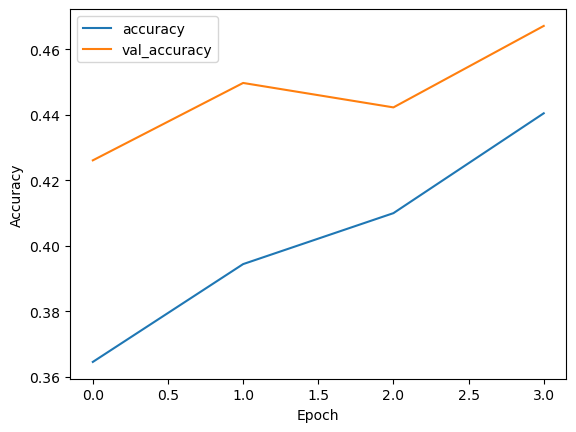

In [83]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Ajouter dans cette cellule :
    # - Des images tirées aléatoirement
    # - La classe reelle
    # - La classe prédite par le modèle

# Sauvegarde du modèle

In [30]:
# Changer le nom du modèle si il s'agit d'un nouvel entrainement
nom_modele = '../model/gpot_v01_echantillon'

In [31]:
model.save(nom_modele)

INFO:tensorflow:Assets written to: ../model/gpot_v01_echantillon\assets


INFO:tensorflow:Assets written to: ../model/gpot_v01_echantillon\assets


# Pour aller plus loin : Optuna

La bibliothèque Optuna est une bibliothèque open source en Python qui est principalement utilisée pour l'optimisation des hyperparamètres, également connue sous le nom d'optimisation automatique des hyperparamètres (AutoML). Elle permet d'automatiser le processus de recherche des meilleures combinaisons d'hyperparamètres pour les modèles d'apprentissage automatique, ce qui peut grandement améliorer les performances des modèles.

**Voici les principales utilisations et fonctionnalités de la bibliothèque Optuna :**
- Optimisation des hyperparamètres : Optuna peut rechercher automatiquement les meilleures valeurs d'hyperparamètres pour un modèle donné en minimisant ou maximisant une fonction objectif. Les hyperparamètres sont des paramètres qui ne sont pas appris par le modèle lui-même, mais qui affectent ses performances, tels que le taux d'apprentissage, la profondeur du réseau de neurones, la taille du lot, etc.

- Gestion des essais : Optuna gère la recherche des hyperparamètres en effectuant une recherche efficace dans l'espace des hyperparamètres en utilisant des algorithmes d'optimisation tels que l'optimisation des arbres de décision, l'optimisation bayésienne, etc. Il maintient un historique des essais antérieurs pour guider la recherche.

- Intégration avec les frameworks de machine learning : Optuna peut être utilisé avec différents frameworks d'apprentissage automatique, tels que TensorFlow, PyTorch, Scikit-Learn, XGBoost, LightGBM, etc. Il est donc polyvalent et peut être utilisé pour optimiser divers types de modèles.

- Extensible : Optuna est extensible, ce qui signifie que vous pouvez définir votre propre espace d'hyperparamètres à rechercher et définir des objectifs personnalisés en fonction de votre problème spécifique.

- Parallélisme : Optuna prend en charge le parallélisme, ce qui signifie que vous pouvez effectuer plusieurs essais en parallèle pour accélérer le processus d'optimisation.

- Visualisation des résultats : Optuna offre des outils de visualisation pour vous permettre d'analyser les résultats de l'optimisation, tels que les graphiques d'importance des hyperparamètres, les courbes d'apprentissage, etc.


En résumé, Optuna est une bibliothèque puissante pour l'optimisation des hyperparamètres qui permet d'automatiser et de rationaliser le processus de recherche des meilleures configurations de modèle, ce qui peut vous faire gagner du temps et améliorer considérablement les performances de vos modèles d'apprentissage automatique.

### Librairies à importer pour Optuna

In [56]:
import optuna
import optuna.visualization as optuna_viz
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model

### Fonction objectif

Vous devez définir une fonction objectif que vous souhaitez optimiser. Cette fonction prendra les hyperparamètres comme arguments et renverra une valeur que vous souhaitez minimiser ou maximiser.

In [59]:
def objective(trial):
    # Paramètres à optimiser
        # Nombre de couches cachées
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 5)
            # Nombre de couches dropout
    dropout_rates = [trial.suggest_float(f'dropout_layer_{i}', 0.0, 0.5) for i in range(num_hidden_layers)]
        # Learning rate
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)


    # Créer le modèle EfficientNetB0 pré-entraîné avec des couches gelées
    base_model = pre_train_model

    # Geler toutes les couches du modèle de base
    for layer in base_model.layers:
        layer.trainable = False

    # Ajouter des couches personnalisées pour la classification
    x = base_model.output
    
    for i in range(num_hidden_layers):
        x = Dense(128, activation='relu')(x)
        x = Dropout(dropout_rates[i])(x)

    predictions = Dense(10, activation='softmax')(x)

    # Créer le modèle complet
    model = Model(inputs=pre_train_model.input, outputs=predictions)

    # Compiler le modèle
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Entraîner le modèle
    optuna_history = model.fit(ds_train, validation_data=ds_val, epochs=5, batch_size=batch_size, verbose=0)

    # Évaluer la précision sur l'ensemble de test
    y_pred = model.predict(ds_test)
    y_pred = tf.argmax(y_pred, axis=1).numpy()
    accuracy = accuracy_score(y_test, y_pred)

    return -accuracy  # Maximiser la précision (donc minimiser l'opposé)


### Objet d'étude Optuna

Vous devez créer un objet d'étude Optuna et spécifier la direction de l'optimisation (minimisation ou maximisation) 

La différence entre les modes "minimize" et "maximize" dans une étude Optuna réside dans la manière dont Optuna interprète la fonction objectif que vous cherchez à optimiser.

**Minimize (Minimiser) :**

Lorsque vous spécifiez direction='minimize' lors de la création de votre étude Optuna, vous indiquez à Optuna que vous cherchez à minimiser la valeur de la fonction objectif.
Cela signifie que vous cherchez à obtenir la plus petite valeur possible de la fonction objectif. Par exemple, si vous utilisez la perte d'un modèle de machine learning comme fonction objectif, vous souhaitez minimiser cette perte (c'est-à-dire obtenir une perte aussi faible que possible).


**Maximize (Maximiser) :**

En revanche, lorsque vous spécifiez direction='maximize', vous indiquez à Optuna que vous cherchez à maximiser la valeur de la fonction objectif.
Cela signifie que vous cherchez à obtenir la plus grande valeur possible de la fonction objectif. Par exemple, si vous cherchez à maximiser la précision d'un modèle de classification, vous souhaitez obtenir une précision aussi élevée que possible.
Le choix entre "minimize" et "maximize" dépend du problème que vous résolvez et de la manière dont vous définissez votre fonction objectif. Par exemple, si vous cherchez à minimiser les erreurs, les pertes ou les coûts, vous utiliserez généralement "minimize". Si vous cherchez à maximiser les performances, les scores ou les gains, vous utiliserez généralement "maximize".




**Voici un exemple concret :** supposons que vous entraîniez un modèle de classification et que votre fonction objectif est la précision du modèle. Dans ce cas, vous voudriez spécifier direction='maximize' car vous cherchez à obtenir la meilleure précision possible. D'un autre côté, si vous optimisez la perte du modèle, vous spécifierez direction='minimize' car vous voulez minimiser la perte.

In [60]:
study = optuna.create_study(direction='minimize')  # Vous pouvez également utiliser 'maximize'

[I 2023-09-06 18:39:20,959] A new study created in memory with name: no-name-3f84819b-00f9-4251-bcbb-6862d236f9ec


### Lancer l'optimisation 

Utilisez la méthode optimize de l'objet d'étude en spécifiant la fonction objectif et le nombre d'essais que vous souhaitez effectuer

In [ ]:
# /!\ Attention l'entrainement peut être très très long
study.optimize(objective, n_trials=5)  # Vous pouvez ajuster le nombre d'essais

### Accéder aux résultats

Une fois l'optimisation terminée, vous pouvez accéder aux meilleurs hyperparamètres et à la meilleure valeur obtenue

In [68]:
best_params = study.best_params
best_value = study.best_value
print(best_params)

{'num_hidden_layers': 5, 'dropout_layer_0': 0.29814465457771433, 'dropout_layer_1': 0.3009901578535206, 'dropout_layer_2': 0.164650547536409, 'dropout_layer_3': 0.19192082606985023, 'dropout_layer_4': 0.19229664969483762, 'learning_rate': 0.01202621313117321}


#### Courbe des performances

In [63]:
optuna_viz.plot_optimization_history(study)

#### Importance des hyperparamètres

In [64]:
optuna_viz.plot_param_importances(study)

#### Distributions des valeurs d'hyperparamètres

In [65]:
optuna_viz.plot_slice(study)

#### Courbe de convergence

In [66]:
optuna_viz.plot_contour(study)

[W 2023-09-06 19:47:19,559] Param dropout_layer_4 unique value length is less than 2.
[W 2023-09-06 19:47:19,561] Param dropout_layer_4 unique value length is less than 2.
[W 2023-09-06 19:47:19,562] Param dropout_layer_4 unique value length is less than 2.
[W 2023-09-06 19:47:19,562] Param dropout_layer_4 unique value length is less than 2.
[W 2023-09-06 19:47:19,564] Param dropout_layer_4 unique value length is less than 2.
[W 2023-09-06 19:47:19,564] Param dropout_layer_4 unique value length is less than 2.
[W 2023-09-06 19:47:19,564] Param dropout_layer_4 unique value length is less than 2.
[W 2023-09-06 19:47:19,565] Param dropout_layer_4 unique value length is less than 2.
[W 2023-09-06 19:47:19,566] Param dropout_layer_4 unique value length is less than 2.
[W 2023-09-06 19:47:19,566] Param dropout_layer_4 unique value length is less than 2.
[W 2023-09-06 19:47:19,567] Param dropout_layer_4 unique value length is less than 2.
[W 2023-09-06 19:47:19,568] Param dropout_layer_4 uniq

#### Histogramme des valeurs d'hyperparamètres

In [67]:
optuna_viz.plot_parallel_coordinate(study)